<a href="https://colab.research.google.com/github/codac-black/machine-learning-deep-learning/blob/main/birdcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded=files.upload()

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.95G/1.96G [00:17<00:00, 144MB/s]
100% 1.96G/1.96G [00:17<00:00, 118MB/s]


In [ ]:
!unzip 100-bird-species.zip

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.layers import Rescaling
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

### Load Data

In [ ]:
df = pd.read_csv('/content/birds.csv')

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.isna().sum()

In [ ]:
for i in df.columns:
  print(f'{i}: {len(i)}')

In [ ]:
base_dir = '/content/train'
directories = os.listdir(base_dir)
directories.sort()
for dir in directories:
  dir_path = os.path.join(base_dir, dir)
  if os.path.isdir(dir_path):
    files = os.listdir(dir_path)
    file_count = len(files)
  print(f'{dir}: {file_count}')


In [ ]:
base_dir = '/content/test'
directories = os.listdir(base_dir)
directories.sort()
for dir in directories:
  dir_path = os.path.join(base_dir, dir)
  if os.path.isdir(dir_path):
    files = os.listdir(dir_path)
    file_count = len(files)
  print(f'{dir}: {file_count}')

In [ ]:
base_dir = '/content/valid'
directories = os.listdir(base_dir)
directories.sort()
for dir in directories:
  dir_path = os.path.join(base_dir, dir)
  if os.path.isdir(dir_path):
    files = os.listdir(dir_path)
    file_count = len(files)
  print(f'{dir}: {file_count}')

### Data Preprocessing

1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Rescale the pixel values (between 0 and 255) to the ```[0, 1]``` interval (as you know,neural networks prefer to deal with small input values).

In [ ]:
# Listing the directories
train_dir = '/content/train'
test_dir = '/content/test'
valid_dir = '/content/valid'

In [ ]:
# Rescale Images to 1 / 255
train_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. /255)
valid_datagen = ImageDataGenerator(rescale= 1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',

)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',

)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
  print(f'''
  data batch shape: {data_batch.shape}
  labels batch shape: {labels_batch.shape}
  ''')
  break


  data batch shape: (32, 224, 224, 3)
  labels batch shape: (32, 525)
  


In [ ]:
train_directory = '/content/train'

subdir = [name for name in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, name))]
num_classes = len(subdir)

print(f'Num of classes: {num_classes}')

Num of classes: 525


### Model creation

### Using inception v3

In [ ]:
# create a checkpoint callback
checkpoint_path = 'birds_classification_model_checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)


# setup early stopping callbacks to stop training if loss doesn't improve for 5 epochs

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience=3,
    min_lr = 1e-6
)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(
        mode='horizontal',
        seed=42
    ),
    tf.keras.layers.RandomRotation(
        factor=0.05,
        seed=42
    ),
    tf.keras.layers.RandomZoom(0.05, seed=42),
])

In [ ]:
from keras.optimizers import Adam
base_model = tf.keras.applications.InceptionV3(
  include_top=False
)

# Freeze base model

base_model.trainable = False

model_zero = tf.keras.Sequential([
    tf.keras.layers.Input(
        shape=(224,224,3),
        name='Input layer'
    ),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(name='global-layer'),
    tf.keras.layers.Dense(
        525,
        activation = 'softmax',
        name = 'Output-layer'
    )
])


# Compile the model

model_zero.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model_zero.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global-layer (GlobalAverag  (None, 2048)              0         
 ePooling2D)                                                     
                                                                 
 Output-layer (Dense)        (None, 525)               1075725   
                                                                 
Total params: 22878509 (87.27 MB)
Trainable params: 1075725 (4.10 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


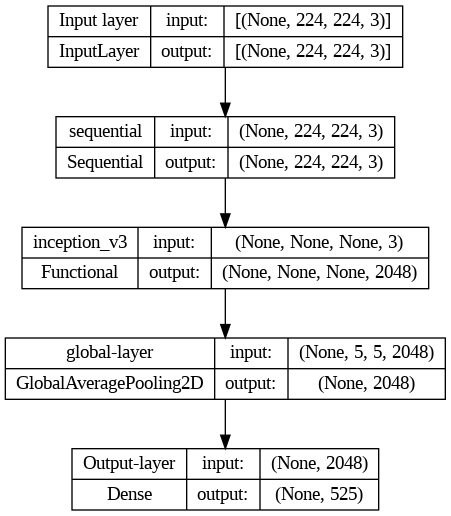

In [ ]:
from tensorflow.keras.utils import plot_model
# Save the model summary to a file
plot_model(model_zero, to_file='modelzero_summary.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model_zero.fit(
    train_generator,
    epochs=20,
    steps_per_epoch = len(train_generator),
    validation_data = validation_generator,
    validation_steps = int(0.25 * len(validation_generator)),
    callbacks = [
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)


Epoch 1/20
2645/2645 [==============================] - 238s 84ms/step - loss: 11.5369 - accuracy: 0.4511 - val_loss: 7.8224 - val_accuracy: 0.6391 - lr: 0.0100
Epoch 2/20
2645/2645 [==============================] - 217s 82ms/step - loss: 9.2267 - accuracy: 0.6275 - val_loss: 7.3319 - val_accuracy: 0.6969 - lr: 0.0100
Epoch 3/20
2645/2645 [==============================] - 218s 82ms/step - loss: 8.4920 - accuracy: 0.6816 - val_loss: 8.1904 - val_accuracy: 0.7078 - lr: 0.0100
Epoch 4/20
2645/2645 [==============================] - 218s 82ms/step - loss: 7.9515 - accuracy: 0.7157 - val_loss: 5.8155 - val_accuracy: 0.7828 - lr: 0.0100
Epoch 5/20
2645/2645 [==============================] - 217s 82ms/step - loss: 7.4220 - accuracy: 0.7425 - val_loss: 7.5467 - val_accuracy: 0.7625 - lr: 0.0100
Epoch 6/20
2645/2645 [==============================] - 216s 82ms/step - loss: 7.1004 - accuracy: 0.7602 - val_loss: 5.5049 - val_accuracy: 0.8156 - lr: 0.0100
Epoch 7/20
2645/2645 [=================

### Fine tuned model

In [ ]:
# Unfreezing the last layers

base_model.trainable = True

for layer in base_model.layers[:-22]:
  layer.trainable = False

  # reduce lr to a factor of 10 before fine tuning
  # recompile the model every time there's a change
  model_zero.compile(
      loss='categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
      metrics = ['accuracy']
  )

In [ ]:
model_zero.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, None   0         
                             )                                   
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global-layer (GlobalAverag  (None, 2048)              0         
 ePooling2D)                                                     
                                                                 
 Output-layer (Dense)        (None, 525)               1075725   
                                                                 
Total params: 22878509 (87.27 MB)
Trainable params: 3895821 (14.86 MB)
Non-trainable params: 18982688 (72.41 MB)
_______

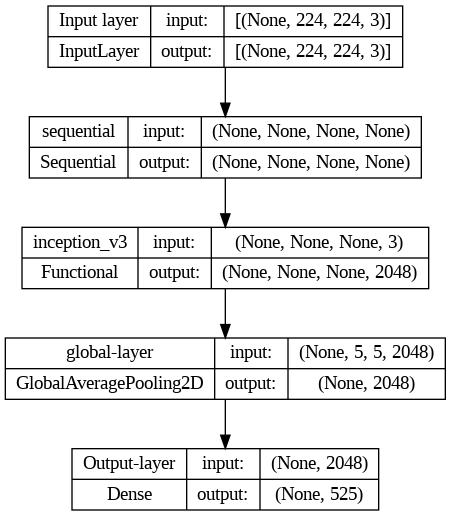

In [ ]:
from tensorflow.keras.utils import plot_model
# Save the model summary to a file
plot_model(model_zero, to_file='modelzero_summary.png', show_shapes=True, show_layer_names=True)

In [ ]:
history_tuned = model_zero.fit(
    train_generator,
    epochs = 30,
    steps_per_epoch = len(train_generator),
    validation_data = validation_generator,
    validation_steps = int(0.25 * len(validation_generator)),
    callbacks = [
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/50
2645/2645 [==============================] - 257s 87ms/step - loss: 1.4926 - accuracy: 0.8960 - val_loss: 2.4506 - val_accuracy: 0.8703 - lr: 1.0000e-04
Epoch 2/50
2645/2645 [==============================] - 228s 86ms/step - loss: 1.1195 - accuracy: 0.9099 - val_loss: 2.2776 - val_accuracy: 0.8641 - lr: 1.0000e-04
Epoch 3/50
2645/2645 [==============================] - 225s 85ms/step - loss: 0.8890 - accuracy: 0.9184 - val_loss: 1.6439 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 4/50
2645/2645 [==============================] - 225s 85ms/step - loss: 0.7624 - accuracy: 0.9247 - val_loss: 1.2208 - val_accuracy: 0.9125 - lr: 1.0000e-04
Epoch 5/50
2645/2645 [==============================] - 226s 85ms/step - loss: 0.6280 - accuracy: 0.9326 - val_loss: 1.6839 - val_accuracy: 0.8984 - lr: 1.0000e-04
Epoch 6/50
2645/2645 [==============================] - 227s 86ms/step - loss: 0.5445 - accuracy: 0.9380 - val_loss: 1.4244 - val_accuracy: 0.8984 - lr: 1.0000e-04
Epoch 7/50
2645/

In [ ]:
model_zero.save('birds_classification_inceptionv3.keras')
model_zero.save('birds_classification_inceptionv3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
results = model_zero.evaluate(
    test_generator,
    verbose=0
)

print(f'''
  Test Loss 🐌: {results[0] :.3f}
  Test Accuracy 🎯: {results[1] * 100 :.3f}
''')


  Test Loss 🐌: 0.632
  Test Accuracy 🎯: 94.286



In [ ]:
results = model_zero.evaluate(
    validation_generator,
    verbose=0
)

print(f'''
  Validation Loss 🐌: {results[0] :.3f}
  Validation Accuracy 🎯: {results[1] * 100 :.3f}
''')


  Validation Loss 🐌: 0.973
  Validation Accuracy 🎯: 91.848



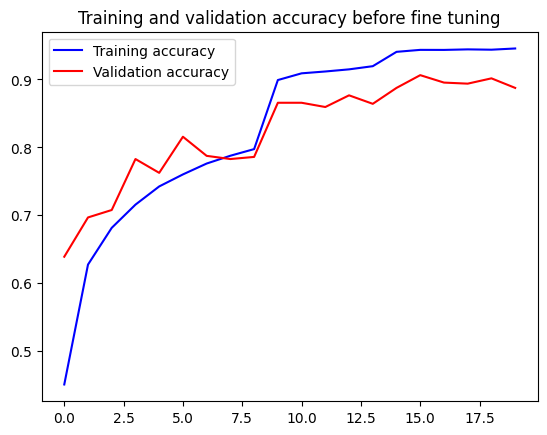

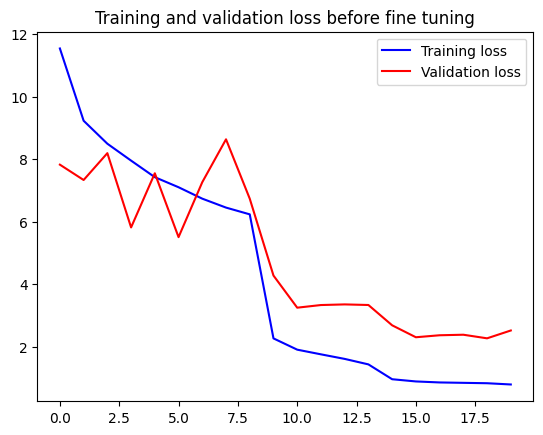

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy before fine tuning')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss before fine tuning')
plt.legend()
plt.show()

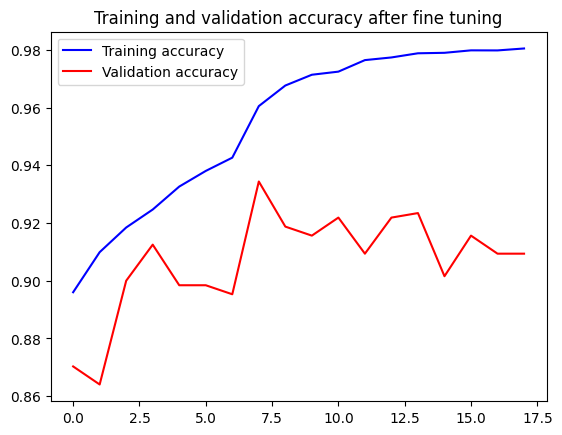

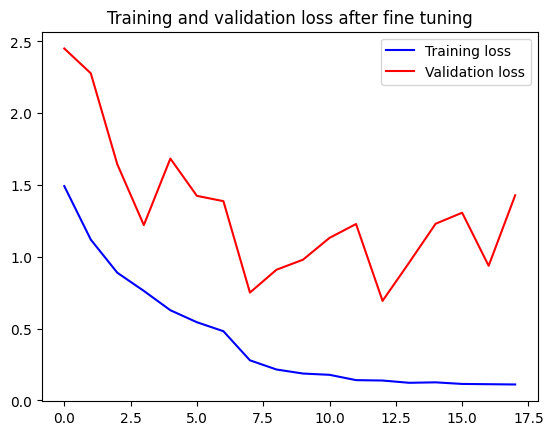

In [ ]:
accuracy = history_tuned.history['accuracy']
val_accuracy = history_tuned.history['val_accuracy']

loss = history_tuned.history['loss']
val_loss = history_tuned.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy after fine tuning')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss after fine tuning')
plt.legend()
plt.show()

In [ ]:
labels = (test_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())

1/1 [==============================] - 0s 29ms/step


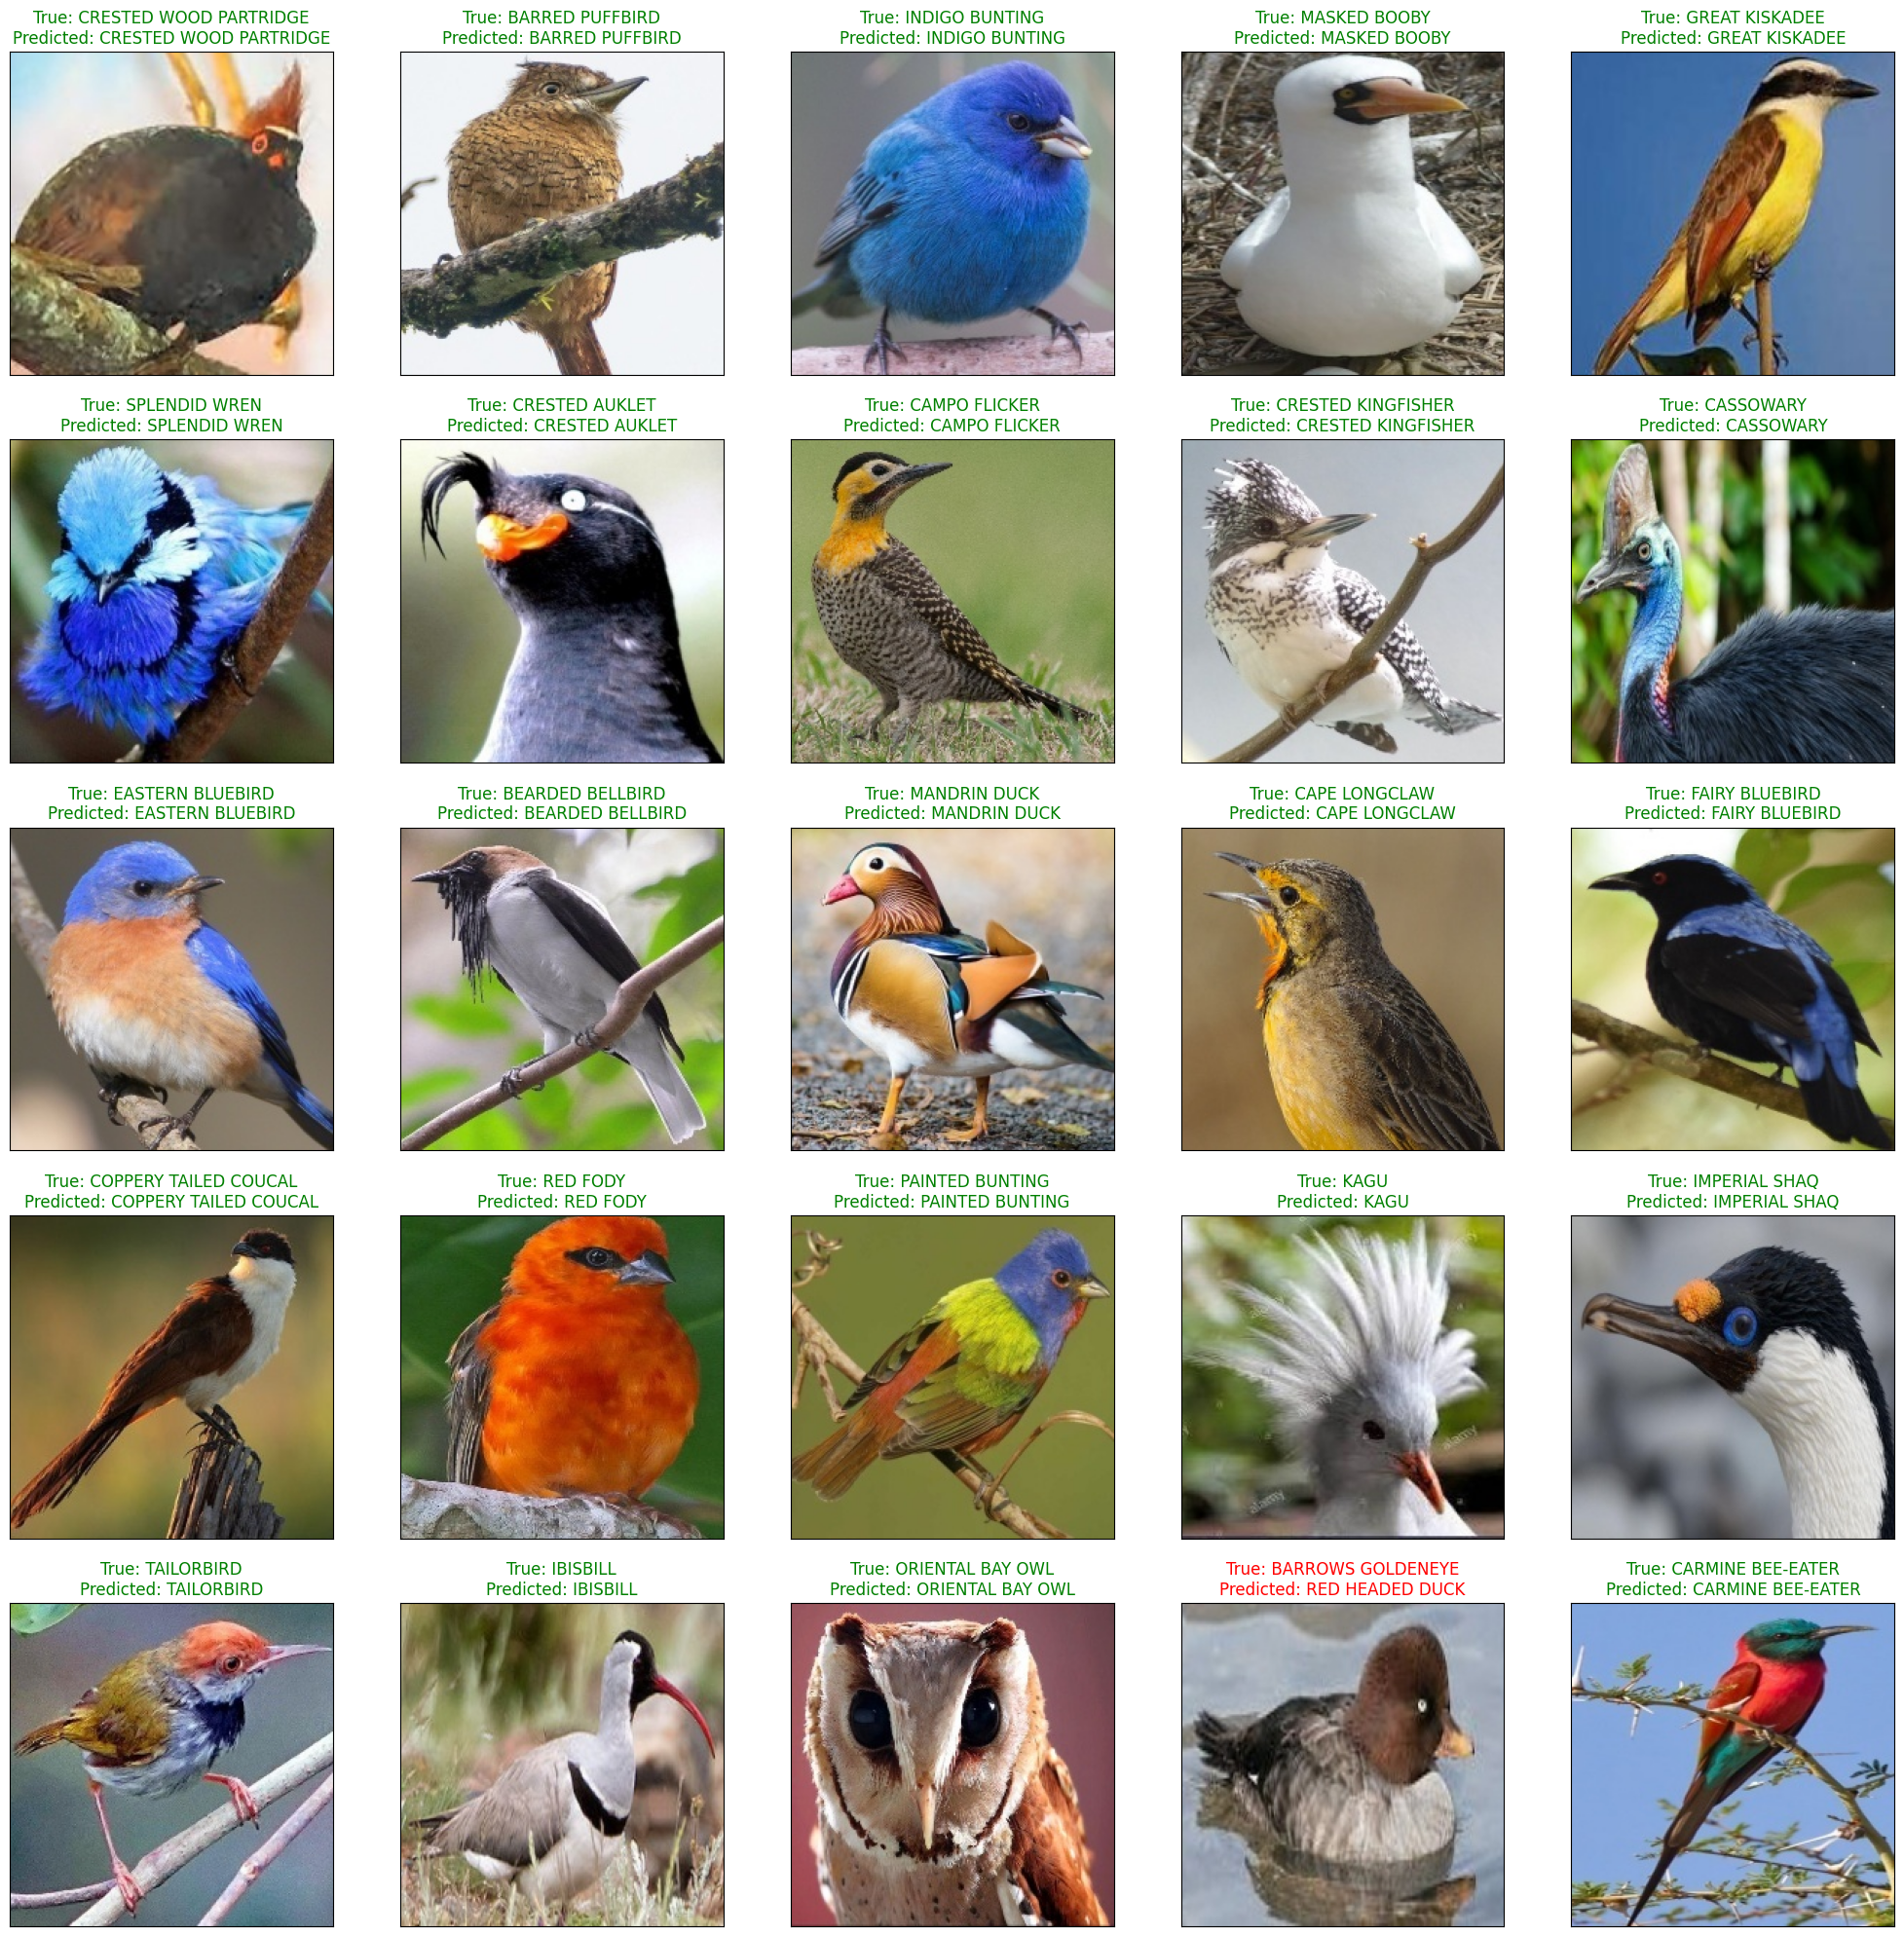

<Figure size 640x480 with 0 Axes>

In [ ]:
firstdim=np.random.randint(0,82,25)
thirddim=np.random.randint(0,31,25)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25),
                        subplot_kw={'xticks': [], 'yticks': []})


for i, ax in enumerate(axes.flat):
    ax.imshow(test_generator[firstdim[i]][0][thirddim[i]])
    truelabel=np.argmax(test_generator[firstdim[i]][1][thirddim[i]])
    image = tf.keras.preprocessing.image.img_to_array(test_generator[firstdim[i]][0][thirddim[i]])
    image = np.expand_dims(image, axis=0)
    prediction = np.argmax(model_zero.predict(image))
    if truelabel == prediction:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {labels[truelabel]}\nPredicted: {labels[prediction]}", color=color)
plt.show()
plt.tight_layout()